# Libraries

In [1]:
import ast
import math
import os
import gc

import cv2
from pathlib import Path

from PIL import Image, ImageSequence
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelextrema
# from skfda import FDataGrid
from numpy import unravel_index
import statistics
import heapq
import pandas as pd

# import tensorflow as tf
# from tensorflow.keras import layers, models

import itertools

# Functions

## Smoothing

In [2]:
def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

In [3]:
def merge_peaks_by_distance(peaks, min_distance):
    merged_peaks = []
    i = 0
    while i < len(peaks) - 1:
        if abs(peaks[i] - peaks[i+1]) <= min_distance:
            merged_peak = (peaks[i] + peaks[i+1]) // 2
            merged_peaks.append(merged_peak)
            i += 2  
        else:
            merged_peaks.append(peaks[i])
            i += 1

    if i == len(peaks) - 1:
        merged_peaks.append(peaks[i])
    return merged_peaks


## Circle functions

In [16]:
def circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow):
    # Adjusted peak selection to use closest peaks around ccol
    closest_peak_x = min(peaks_x, key=lambda x: abs(x-ccol))
    closest_peak_y = min(peaks_y, key=lambda y: abs(y-crow))

    # Using peak indices to find distances to closest peaks
    peak_index_x = peaks_x.tolist().index(closest_peak_x)
    peak_index_y = peaks_y.tolist().index(closest_peak_y)
    # peak_index_x=peaks_x.index(closest_peak_x)
    # peak_index_y=peaks_y.index(closest_peak_y)

    if peak_index_x > 0:
        rl_x = ccol - peaks_x[peak_index_x - ring_index]
        rr_x = peaks_x[peak_index_x + ring_index] - ccol

    if peak_index_y > 0:
        ru_y = crow - peaks_y[peak_index_y - ring_index]
        rl_y = peaks_y[peak_index_y + ring_index] - crow


    return round((rl_x + rr_x + ru_y + rl_y) / 4., 0)

In [17]:
def circle_change_limiter(circle_radius,prev_circle_radius,allowed_change,ring_index,peaks_x,peaks_y,ccol,crow):
    if prev_circle_radius is not None and circle_radius > prev_circle_radius * (1+allowed_change) and ring_index != 1:
        ring_index=ring_index-1
        # ccol=prev_ccol
        # crow=prev_crow
        print(f'{circle_radius} high')
        circle_radius=circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
    elif prev_circle_radius is not None and circle_radius < prev_circle_radius * (1-allowed_change):
        print(prev_circle_radius * 1-allowed_change)
        ring_index=ring_index+1
        # ccol=prev_ccol
        # crow=prev_crow
        print('low')
        circle_radius=circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
    return circle_radius,ring_index

In [18]:
def get_center_from_peaks(peaks, current_center):
    valid_peaks = [peak for peak in peaks if np.abs(peak - current_center) >= 10]
    left_peaks = np.array([peak for peak in valid_peaks if peak < current_center])
    right_peaks = np.array([peak for peak in valid_peaks if peak > current_center])

    if len(left_peaks) == 0 or len(right_peaks) == 0:
        return current_center, 0

    left_peak = left_peaks[-1] 
    right_peak = right_peaks[0] 

    refined_center = (left_peak + right_peak) // 2
    # print(f'current: {current_center}, left_peak: {left_peak}, right_peak: {right_peak}, refined center: {refined_center}\n {left_peaks} || {right_peaks}')

    distance_between_peaks = np.abs(right_peak - left_peak)

    return refined_center, distance_between_peaks

In [19]:
def adaptive_movement_threshold(prev_ccol, prev_crow, ccol, crow, prev_movement, allowed_change=5):
    # movement
    if prev_ccol != None and prev_crow!= None:
        distance = np.linalg.norm([ccol - prev_ccol, crow - prev_crow])
        print(distance)
        
        # if the center moves in the video, increase allowance
        if distance > prev_movement:
            allowed_change = min(distance, allowed_change * 2)
        
        # Allow movement if it is within the allowed range
        if distance <= allowed_change:
            return ccol, crow, distance
        else:
            # Reject large shifts
            return prev_ccol, prev_crow, prev_movement
    else:
        return ccol,crow,prev_movement


In [20]:
def get_center_from_minimums(minimums, current_center,min_depth=0.25):
    # Filter minimums based on a minimum distance from the current center (to avoid noise)
    valid_minimums = [minm for minm in minimums if np.abs(minm - current_center) >= 10]
    left_minimums = np.array([minm for minm in valid_minimums if minm < current_center])
    right_minimums = np.array([minm for minm in valid_minimums if minm > current_center])

    # Ensure there are valid minimums on both sides of the current center
    if len(left_minimums) == 0 or len(right_minimums) == 0:
        return current_center, 0

    # Take the second-to-last left minimum and second right minimum as references
    left_minimum = left_minimums[-2]  # Adjust indexing as needed
    right_minimum = right_minimums[1]  # Adjust indexing as needed

    # Compute the refined center based on the left and right minimums
    refined_center = (left_minimum + right_minimum) // 2
    # print(f'current: {current_center}, left_minimum: {left_minimum}, right_minimum: {right_minimum}, refined center: {refined_center}')

    # Compute the distance between the two reference minimums
    distance_between_minimums = np.abs(right_minimum - left_minimum)

    return refined_center, distance_between_minimums


In [21]:
def draw_circle(image,ccol,crow,circle_radius):
    cross_length=10

    circle_img = cv2.circle(image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
    cv2.line(circle_img,(ccol - cross_length, crow), (ccol + cross_length, crow), (255, 255, 255), 1)
    cv2.line(circle_img, (ccol, crow - cross_length), (ccol, crow + cross_length), (255, 255, 255), 1)
    
    return circle_img

## Image extraction and exploration

In [2]:
def image_background_brightness(image):
        top_left = image[0:5, 0:5]
        top_right = image[0:5, -5:]
        bottom_left = image[-5:, 0:5]
        bottom_right = image[-5:, -5:]
        brightness = np.concatenate((top_left.flatten(), top_right.flatten(), 
                                  bottom_left.flatten(), bottom_right.flatten()))
        # brightness=top_left+top_right+bottom_left+bottom_right

        return [np.mean(brightness),np.median(brightness),statistics.mode(brightness)]

In [3]:
def tiff_to_png(input_tiff, input_path, output_path):
    try:
        sq = Image.open(os.path.join(input_path, input_tiff))
        for i, img in enumerate(ImageSequence.Iterator(sq)):
            output = os.path.join(output_path, f"frame_{i:06d}.png")
            img.save(output)
    finally:
        # print("PNG extraction done")
        sq.close()

In [4]:
def get_first_png(input_tiff, input_path):
    try:
        sq = Image.open(os.path.join(input_path, input_tiff))
        first_frame = next(ImageSequence.Iterator(sq))
        first_frame_np = np.array(first_frame)
        if first_frame_np.ndim == 2:
            return first_frame_np
        else:
            return cv2.cvtColor(first_frame_np, cv2.COLOR_RGB2GRAY)
    finally:
        # print("PNG extraction done")
        sq.close()

In [5]:
def pad_image(image, target_size=(512, 512), padding_value=0):
    old_height, old_width = image.shape

    # Padding sizes
    top_pad = (target_size[0] - old_height) // 2
    bottom_pad = target_size[0] - old_height - top_pad
    left_pad = (target_size[1] - old_width) // 2
    right_pad = target_size[1] - old_width - left_pad

    padded_image = np.pad(image, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant', constant_values=padding_value)

    return padded_image

## Post processing

In [29]:
def interpolation(data):
    return(np.interp([i for i in range(1,len(data)*50)],xp=[i*50 for i in range(0,len(data))],fp=data))

In [15]:
preProcData=pd.read_excel(f'Excels/VideoVideo1_37_1.xlsx')
data=preProcData['center_y(ccol)']
df = pd.DataFrame(columns=['center_y(ccol)'])
df_append= pd.DataFrame(columns=['center_y(ccol)'])
new_data={'center_y(ccol)':interpolation(data)}
df = pd.concat([df, pd.DataFrame(interpolation(data))], ignore_index=True)
df.to_excel('Csv.xlsx')

In [55]:
def post_processing(r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path,interpolationP=True):
    movement_threshold=70 #Sum of all center movements in a video
    cross_length = 10 #Center cross

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    test_number=input_tiff.split('.')[0]

    result_folder = f"Results_Validation_49_Interpolated_Median/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"
    Path(result_folder).mkdir(parents=True, exist_ok=True)

    preProcData=pd.read_excel(f'Excels49/Video{test_number}_{r_in}{r_out}_{ring_index}.xlsx')
    if (interpolationP==True):
        center_x_interpolated=interpolation(preProcData['center_x(crow)'])
        center_y_interpolated=interpolation(preProcData['center_y(ccol)'])
        circle_radius_interpolated=interpolation(preProcData['circle_radius'])
        window=50

        dfList=list(zip(center_x_interpolated,center_y_interpolated,circle_radius_interpolated))
        preProcData=pd.DataFrame(dfList,columns=['center_x(crow)','center_y(ccol)','circle_radius'])
    else:
        window = 3

    # calculating the sum of differences of the center (moving bead or stationary)
    preProcData['diff_center_y'] = preProcData['center_y(ccol)'].diff().abs().fillna(0)
    preProcData['diff_center_x'] = preProcData['center_x(crow)'].diff().abs().fillna(0)
    # preProcData['total_movement'] = preProcData['diff_center_y'] + preProcData['diff_center_x']
    totalMovement=0

    for index, row in preProcData.iterrows():
        totalMovement=totalMovement+row['diff_center_x']+row['diff_center_y']

    preProcData['smooth_center_y(ccol)'] = preProcData['center_y(ccol)'].rolling(window=window).median()
    preProcData['smooth_center_x(crow)'] = preProcData['center_x(crow)'].rolling(window=window).median()
    preProcData['smooth_radius'] = preProcData['circle_radius'].rolling(window=window).median()  

    # print(preProcData)

    preProcData.fillna(method='bfill', inplace=True) # for the beginning
    # .rolling(window=3)
    df = pd.DataFrame(columns=['center_y(ccol)', 'center_x(crow)', 'circle_radius'])
    # if(totalMovement<movement_threshold or totalMovement>movement_threshold):
    print (totalMovement)
    if(totalMovement<movement_threshold):
        i = 0
        for filename in os.listdir(output_path):
            file_path = os.path.join(output_path, filename)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            ccol=int(preProcData['smooth_center_y(ccol)'][i])
            crow=int(preProcData['smooth_center_x(crow)'][i])

            movementNearFramesX=preProcData['diff_center_x'][i:i+100].sum()
            movementNearFramesY=preProcData['diff_center_y'][i:i+100].sum()

            if((movementNearFramesX+movementNearFramesY)>10):
                ccol=int(preProcData['center_y(ccol)'][i])
                crow=int(preProcData['center_x(crow)'][i])

            circle_radius=int(preProcData['circle_radius'][i])

            new_data={'center_y(ccol)':ccol,'center_x(crow)':crow,'circle_radius':circle_radius}
            df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)

            circle_img=draw_circle(image,ccol,crow,circle_radius)
            
            plt.imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            plt.savefig(os.path.join(result_folder, f"result_{filename}.png"))
            # plt.show()

            i+=50
    else:
        i = 0
        # print(os.listdir(output_path))
        for filename in os.listdir(output_path):
            # print(filename)
            file_path = os.path.join(output_path, filename)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            # movementNearFramesX=preProcData['diff_center_x'][nearFrameStart:nearFrameEnd].sum()
            # movementNearFramesY=preProcData['diff_center_y'][nearFrameStart:nearFrameEnd].sum()

            # print(f'frameNo = {i}, x_movement near = {movementNearFramesX}, y_movement near = {movementNearFramesY}')

            # if ((movementNearFramesX+movementNearFramesY)>20):    
            ccol=int(preProcData['center_y(ccol)'][i])
            crow=int(preProcData['center_x(crow)'][i])
            circle_radius=int(preProcData['circle_radius'][i])
            # else:
            #     ccol=int(preProcData['smooth_center_y(ccol)'][i])
            #     crow=int(preProcData['smooth_center_x(crow)'][i])
            #     circle_radius=int(preProcData['circle_radius'][i])

            circle_img=draw_circle(image,ccol,crow,circle_radius)
            
            plt.imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            plt.savefig(os.path.join(result_folder, f"result_{filename}"))
            # plt.show()
            i+=50

    # df.to_excel(f"Video{test_number}_{r_in}{r_out}_median.xlsx")
    # preProcData.to_excel(f"Video{test_number}_{r_in}{r_out}_preproc.xlsx")
    del image
    plt.close('all')
    gc.collect()
    


    

In [17]:
test=9
input_path='Tiffs_Validation'
input_tiff=f'Video{test}.tif'
params={
    'r_in':6,
    'r_out':9,
    'ring_index':2,
    'allowed_change':1,
    'input_path':input_path,
    'input_tiff':input_tiff,
    'output_base_path':f'Results_Validation/Video{test}'
}
post_processing(**params)

C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14992\2899681204.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


67.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


96.94


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


22.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


7.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


11.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


5.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


24.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


28.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


161.99999999999937


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


130.9799999999998


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


97.97999999999999
[Errno 2] No such file or directory: 'Excels49/VideoVideo1_69_1.xlsx'
6.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


146.00000000000006


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


137.99999999999986


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


320.9999999999984


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


45.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


78.98


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


154.97999999999985


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


67.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


3.9799999999999898
400
96.94


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


22.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


7.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


11.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


5.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


24.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


28.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


161.99999999999937
[Errno 2] No such file or directory: 'Excels49/VideoVideo9_37_2.xlsx'
97.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


[Errno 2] No such file or directory: 'Excels49/VideoVideo1_69_2.xlsx'
6.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


146.00000000000006


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


137.99999999999986


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


320.9999999999984


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


45.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


78.98


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


154.97999999999985


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


67.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_106660\801848442.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


3.9799999999999898
400


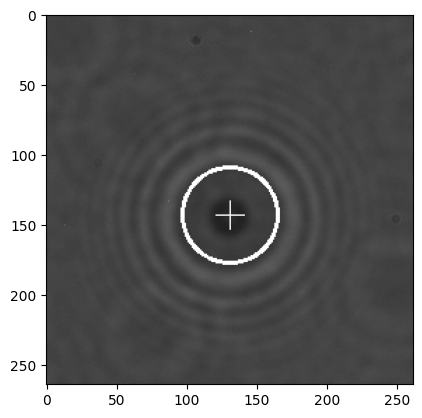

In [57]:
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':3,
        'r_out':7,
        'ring_index':1,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}',
        'interpolationP':True
    }
    try:
        post_processing(**params)
    except Exception as e:
        print(e)
        continue
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':6,
        'r_out':9,
        'ring_index':1,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}',
        'interpolationP':True
    }
    try:
        post_processing(**params)
    except Exception as e:
        print(e)
        continue

for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':3,
        'r_out':7,
        'ring_index':2,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}',
        'interpolationP':True
    }
    try:
        post_processing(**params)
    except Exception as e:
        print(e)
        continue
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':6,
        'r_out':9,
        'ring_index':2,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}',
        'interpolationP':True
    }
    try:
        post_processing(**params)
    except Exception as e:
        print(e)
        continue

In [160]:
def post_processing_mean(r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path,interpolationP=True):
    movement_threshold=70 #Sum of all center movements in a video
    cross_length = 10 #Center cross

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    test_number=input_tiff.split('.')[0]

    result_folder = f"Results_Validation_Interpolated_Mean/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"
    Path(result_folder).mkdir(parents=True, exist_ok=True)

    preProcData=pd.read_excel(f'Excels/Video{test_number}_{r_in}{r_out}_{ring_index}.xlsx')
    if (interpolationP==True):
        center_x_interpolated=interpolation(preProcData['center_x(crow)'])
        center_y_interpolated=interpolation(preProcData['center_y(ccol)'])
        circle_radius_interpolated=interpolation(preProcData['circle_radius'])
        window=50

        dfList=list(zip(center_x_interpolated,center_y_interpolated,circle_radius_interpolated))
        preProcData=pd.DataFrame(dfList,columns=['center_x(crow)','center_y(ccol)','circle_radius'])
    else:
        window = 3

    # calculating the sum of differences of the center (moving bead or stationary)
    preProcData['diff_center_y'] = preProcData['center_y(ccol)'].diff().abs().fillna(0)
    preProcData['diff_center_x'] = preProcData['center_x(crow)'].diff().abs().fillna(0)
    # preProcData['total_movement'] = preProcData['diff_center_y'] + preProcData['diff_center_x']
    totalMovement=0

    for index, row in preProcData.iterrows():
        totalMovement=totalMovement+row['diff_center_x']+row['diff_center_y']

    preProcData['smooth_center_y(ccol)'] = preProcData['center_y(ccol)'].rolling(window=window).mean()
    preProcData['smooth_center_x(crow)'] = preProcData['center_x(crow)'].rolling(window=window).mean()
    preProcData['smooth_radius'] = preProcData['circle_radius'].rolling(window=window).mean()  

    # print(preProcData)

    preProcData.fillna(method='bfill', inplace=True) # for the beginning
    # .rolling(window=3)
    df = pd.DataFrame(columns=['center_y(ccol)', 'center_x(crow)', 'circle_radius'])
    # if(totalMovement<movement_threshold or totalMovement>movement_threshold):
    print (totalMovement)
    if(totalMovement<movement_threshold):
        i = 0
        for filename in os.listdir(output_path):
            file_path = os.path.join(output_path, filename)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            ccol=int(preProcData['smooth_center_y(ccol)'][i])
            crow=int(preProcData['smooth_center_x(crow)'][i])

            movementNearFramesX=preProcData['diff_center_x'][i:i+100].sum()
            movementNearFramesY=preProcData['diff_center_y'][i:i+100].sum()

            if((movementNearFramesX+movementNearFramesY)>10):
                ccol=int(preProcData['center_y(ccol)'][i])
                crow=int(preProcData['center_x(crow)'][i])

            circle_radius=int(preProcData['circle_radius'][i])

            new_data={'center_y(ccol)':ccol,'center_x(crow)':crow,'circle_radius':circle_radius}
            df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)

            circle_img=draw_circle(image,ccol,crow,circle_radius)
            
            plt.imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            plt.savefig(os.path.join(result_folder, f"result_{filename}.png"))
            # plt.show()

            i+=50
    else:
        i = 0
        # print(os.listdir(output_path))
        for filename in os.listdir(output_path):
            # print(filename)
            file_path = os.path.join(output_path, filename)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            # movementNearFramesX=preProcData['diff_center_x'][nearFrameStart:nearFrameEnd].sum()
            # movementNearFramesY=preProcData['diff_center_y'][nearFrameStart:nearFrameEnd].sum()

            # print(f'frameNo = {i}, x_movement near = {movementNearFramesX}, y_movement near = {movementNearFramesY}')

            # if ((movementNearFramesX+movementNearFramesY)>20):    
            ccol=int(preProcData['center_y(ccol)'][i])
            crow=int(preProcData['center_x(crow)'][i])
            circle_radius=int(preProcData['circle_radius'][i])
            # else:
            #     ccol=int(preProcData['smooth_center_y(ccol)'][i])
            #     crow=int(preProcData['smooth_center_x(crow)'][i])
            #     circle_radius=int(preProcData['circle_radius'][i])

            circle_img=draw_circle(image,ccol,crow,circle_radius)
            
            plt.imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            plt.savefig(os.path.join(result_folder, f"result_{filename}"))
            # plt.show()
            i+=50

    # df.to_excel(f"Video{test_number}_{r_in}{r_out}_median.xlsx")
    # preProcData.to_excel(f"Video{test_number}_{r_in}{r_out}_preproc.xlsx")
    del image
    plt.close('all')
    gc.collect()
    


    

C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


96.94


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


27.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


7.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


9.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


5.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


28.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


26.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


163.99999999999937


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


192.97999999999814


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


95.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


5.980000000000004


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


124.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


135.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


396.9799999999915


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


47.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


77.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


154.97999999999985


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


67.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


638.9799999999484


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


96.94


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


27.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


7.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


9.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


5.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


28.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


26.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


163.99999999999937


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


95.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


5.980000000000004


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


124.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


135.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


396.9799999999915


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


47.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


77.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


154.97999999999985


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


67.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\2472174573.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


3.9799999999999898


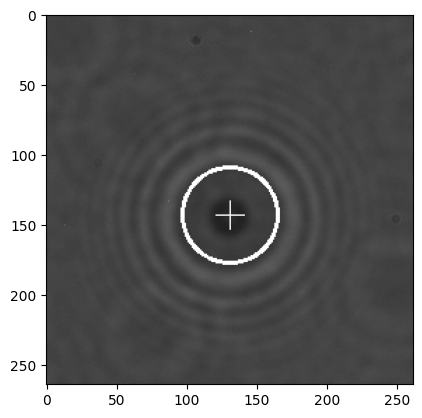

In [161]:
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':3,
        'r_out':7,
        'ring_index':1,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        post_processing_mean(**params)
    except Exception as e:
        continue
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':6,
        'r_out':9,
        'ring_index':1,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        post_processing_mean(**params)
    except Exception as e:
        continue

for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':3,
        'r_out':7,
        'ring_index':2,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        post_processing_mean(**params)
    except Exception as e:
        continue
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':6,
        'r_out':9,
        'ring_index':2,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        post_processing_mean(**params)
    except Exception as e:
        continue

### Wiener filter

In [49]:
from scipy.signal import wiener

In [51]:
def wiener_filter(r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path):
    cross_length = 10 #Center cross

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    test_number=input_tiff.split('.')[0]

    result_folder = f"Results_Validation_Wiener_mixedWindow/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"
    Path(result_folder).mkdir(parents=True, exist_ok=True)

    preProcData=pd.read_excel(f'Excels/Video{test_number}_{r_in}{r_out}_{ring_index}.xlsx')

    center_x_interpolated=interpolation(preProcData['center_x(crow)'])
    center_y_interpolated=interpolation(preProcData['center_y(ccol)'])
    circle_radius_interpolated=interpolation(preProcData['circle_radius'])

    preProcData['diff_center_y'] = preProcData['center_y(ccol)'].diff().abs().fillna(0)
    preProcData['diff_center_x'] = preProcData['center_x(crow)'].diff().abs().fillna(0)
    # preProcData['total_movement'] = preProcData['diff_center_y'] + preProcData['diff_center_x']
    totalMovement=0
    for index, row in preProcData.iterrows():
        totalMovement=totalMovement+row['diff_center_x']+row['diff_center_y']


    if(totalMovement<70):
        wiener_size=250
    else:
        wiener_size=75

    center_x_wiener=wiener(center_x_interpolated, mysize=wiener_size)
    center_y_wiener=wiener(center_y_interpolated,mysize=wiener_size)
    circle_radius_wiener=wiener(circle_radius_interpolated,mysize=wiener_size)

    dfList=list(zip(center_x_wiener,center_y_wiener,circle_radius_wiener))
    preProcData=pd.DataFrame(dfList,columns=['center_x(crow)','center_y(ccol)','circle_radius'])

    

    

    i=0
    for filename in os.listdir(output_path):
        # print(filename)
        file_path = os.path.join(output_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # movementNearFramesX=preProcData['diff_center_x'][nearFrameStart:nearFrameEnd].sum()
        # movementNearFramesY=preProcData['diff_center_y'][nearFrameStart:nearFrameEnd].sum()

        # print(f'frameNo = {i}, x_movement near = {movementNearFramesX}, y_movement near = {movementNearFramesY}')

        # if ((movementNearFramesX+movementNearFramesY)>20):    
        ccol=int(preProcData['center_y(ccol)'][i])
        crow=int(preProcData['center_x(crow)'][i])
        circle_radius=int(preProcData['circle_radius'][i])
        # else:
        #     ccol=int(preProcData['smooth_center_y(ccol)'][i])
        #     crow=int(preProcData['smooth_center_x(crow)'][i])
        #     circle_radius=int(preProcData['circle_radius'][i])

        circle_img=draw_circle(image,ccol,crow,circle_radius)
        
        plt.imshow(circle_img, cmap='gray', vmin=0, vmax=255)
        plt.savefig(os.path.join(result_folder, f"result_{filename}"))
        # plt.show()
        i+=1

        del image
        plt.close('all')
        gc.collect()
    

In [52]:
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':3,
        'r_out':7,
        'ring_index':1,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        wiener_filter(**params)
    except Exception as e:
        print(e)
        continue
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':6,
        'r_out':9,
        'ring_index':2,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        wiener_filter(**params)
    except Exception as e:
        continue
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':6,
        'r_out':9,
        'ring_index':1,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        wiener_filter(**params)
    except Exception as e:
        continue
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':3,
        'r_out':7,
        'ring_index':2,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        wiener_filter(**params)
    except Exception as e:
        continue

c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\

In [18]:
def post_processing2(r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path):
    movement_threshold = 50
    trend_threshold = 3
    cross_length = 10

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    test_number = input_tiff.split('.')[0]

    result_folder = f"Results_Validation/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"
    Path(result_folder).mkdir(parents=True, exist_ok=True)

    preProcData = pd.read_excel(f'Excels/Video{test_number}_{r_in}{r_out}_{ring_index}.xlsx')

    preProcData['diff_center_y'] = preProcData['center_y(ccol)'].diff().abs().fillna(0)
    preProcData['diff_center_x'] = preProcData['center_x(crow)'].diff().abs().fillna(0)

    preProcData['smooth_center_y(ccol)'] = preProcData['center_y(ccol)'].rolling(window=5).mean()
    preProcData['smooth_center_x(crow)'] = preProcData['center_x(crow)'].rolling(window=5).mean()
    preProcData['smooth_radius'] = preProcData['circle_radius'].rolling(window=5).mean()

    preProcData.fillna(method='bfill', inplace=True)

    i = 0
    for filename in os.listdir(output_path):
        file_path = os.path.join(output_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        movementNearFramesX = preProcData['diff_center_x'][i:min(i + trend_threshold, len(preProcData))].sum()
        movementNearFramesY = preProcData['diff_center_y'][i:min(i + trend_threshold, len(preProcData))].sum()

        if (movementNearFramesX + movementNearFramesY) > allowed_change:
            ccol = int(preProcData['center_y(ccol)'][i])
            crow = int(preProcData['center_x(crow)'][i])
        else:
            ccol = int(preProcData['smooth_center_y(ccol)'][i])
            crow = int(preProcData['smooth_center_x(crow)'][i])

        circle_radius = int(preProcData['smooth_radius'][i])

        circle_img = draw_circle(image, ccol, crow, circle_radius)
        plt.imshow(circle_img, cmap='gray', vmin=0, vmax=255)
        plt.savefig(os.path.join(result_folder, f"result_{filename}.png"))
        i += 1

    del image
    plt.close('all')
    gc.collect()


### Kalman filter

In [19]:
from filterpy.kalman import KalmanFilter
def kalman_filter(r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path):
    cross_length = 10 #Center cross

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    test_number=input_tiff.split('.')[0]

    result_folder = f"Results_Kalman/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"
    Path(result_folder).mkdir(parents=True, exist_ok=True)

    df=pd.read_excel(f'Excels/Video{test_number}_{r_in}{r_out}_{ring_index}.xlsx')

    data=np.array(df.drop('Unnamed: 0',axis=1))
    
    def initialize_kalman_filter():
        kf = KalmanFilter(dim_x=6, dim_z=3)  # 6 for x, y, radius + velocities, 3 for the observed x, y, radius
        
        # State transition matrix (x, y, radius, vx, vy, vr)
        dt = 1  # Time step
        kf.F = np.array([[1, 0, 0, dt,  0,  0],  # Position x update
                        [0, 1, 0, 0, dt,  0],  # Position y update
                        [0, 0, 1, 0,  0, dt],  # Radius update
                        [0, 0, 0, 1,  0,  0],  # Velocity x
                        [0, 0, 0, 0,  1,  0],  # Velocity y
                        [0, 0, 0, 0,  0,  1]]) # Velocity radius
        
        kf.H = np.array([[1, 0, 0, 0, 0, 0],  # x position
                        [0, 1, 0, 0, 0, 0],  # y position
                        [0, 0, 1, 0, 0, 0]]) # radius
        
        # Process noise covariance matrix
        kf.Q *= 0.05  # Process noise
        
        # Measurement noise covariance matrix
        kf.R = np.array([[1, 0, 0], 
                        [0, 1, 0],
                        [0, 0, 1]]) * 5  # Measurement noise
        
        # Covariance matrix
        kf.P *= 0.5  # Initial uncertainty
        
        # Initial state (center_x, center_y, radius, velocity_x, velocity_y, velocity_radius)
        kf.x = np.array([data[0, 0], data[0, 1], data[0, 2], 0, 0, 0]) 
        
        return kf
    
    def apply_kalman_filter(data):
        kf = initialize_kalman_filter()
        smoothed_data = []
        
        for i in range(len(data)):
            kf.predict()
            
            # Update the filter with the current measurement
            kf.update(data[i])
            
            smoothed_data.append(kf.x[:3])
        
        return np.array(smoothed_data)

    # Apply the filter to the data
    smoothed_data = apply_kalman_filter(data)

    i = 0
    for filename in os.listdir(output_path):
        file_path = os.path.join(output_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        ccol=int(smoothed_data[:,0][i])
        crow=int(smoothed_data[:,1][i])
        circle_radius=int(smoothed_data[:,2][i])

        # print(f'col - {ccol}, row - {crow}')

        circle_img=draw_circle(image,ccol,crow,circle_radius)

        plt.imshow(circle_img, cmap='gray', vmin=0, vmax=255)
        plt.savefig(os.path.join(result_folder, f"result_k_{filename}"))

        i+=1
        del image
        plt.close('all')
    gc.collect()
    

In [64]:
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':3,
        'r_out':7,
        'ring_index':1,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        post_processing(**params)
    except Exception as e:
        continue

C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


96.94


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


27.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


7.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


9.97999999999999


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


5.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


28.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


26.0


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


163.99999999999937


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


192.97999999999814


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\1050432489.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


95.97999999999999


In [90]:
test=1
input_path='Tiffs_Validation'
input_tiff=f'Video{test}.tif'
params={
    'r_in':3,
    'r_out':7,
    'ring_index':1,
    'allowed_change':1,
    'input_path':input_path,
    'input_tiff':input_tiff,
    'output_base_path':f'Results_Validation/Video{test}'
}
wiener_filter(**params)

c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [82]:
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':6,
        'r_out':9,
        'ring_index':2,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        wiener_filter(**params)
    except Exception as e:
        continue

c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\Tautvydas\AppData\Local\

      center_x(crow)  center_y(ccol)  circle_radius
0             146.02          141.04           36.0
1             146.04          141.08           36.0
2             146.06          141.12           36.0
3             146.08          141.16           36.0
4             146.10          141.20           36.0
...              ...             ...            ...
2494          146.00          142.00           36.0
2495          146.00          142.00           36.0
2496          146.00          142.00           36.0
2497          146.00          142.00           36.0
2498          146.00          142.00           36.0

[2499 rows x 3 columns]
96.94


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_14908\4163287104.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning


KeyboardInterrupt: 

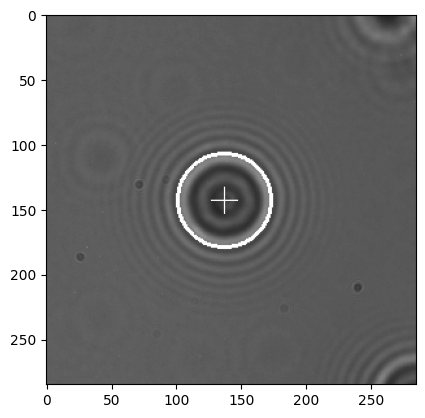

In [60]:
test='1'
input_path='Tiffs_Validation'
input_tiff=f'Video{test}.tif'
params={
    'r_in':3,
    'r_out':7,
    'ring_index':1,
    'allowed_change':1,
    'input_path':input_path,
    'input_tiff':input_tiff,
    'output_base_path':f'Results_Validation/Video{test}'    
}
post_processing(**params)

# main code

In [ ]:
test=i
#     input_path='Tiffs_Validation'
#     input_tiff=f'Video{test}.tif'
#     params={
#         'r_in':3,
#         'r_out':7,
#         'ring_index':1,
#         'allowed_change':1,
#         'input_path':input_path,
#         'input_tiff':input_tiff,
#         'output_base_path':f'Results_Validation/Video{test}'

In [9]:
output_path = Path(f'Results_Validation/VideoLarge') / Path(f'036 melted_ref_beads_steps.ome.tif').stem
output_path.mkdir(parents=True, exist_ok=True)
tiff_to_png(f'036 melted_ref_beads_steps.ome.tif', 'Tiffs', output_path)

KeyboardInterrupt: 

In [19]:
def ring_search(r_in,r_out,ring_index,allowed_change,input_path,input_tiff,output_base_path):
    # autoencoder = tf.keras.models.load_model('autoencoder_model_256.h5')

    brightness_target_median=49
    #  For guarding against index changes
    prev_circle=None
    prev_circle_radius=None
    prev_ccol=None
    prev_crow=None
    prev_movement=0
    cross_length = 10 #Center cross
    ring_index_start=ring_index

    output_path = Path(output_base_path) / Path(input_tiff).stem
    output_path.mkdir(parents=True, exist_ok=True)
    tiff_to_png(input_tiff, input_path, output_path)
    test_number=input_tiff.split('.')[0]
    # print(test_number)

    result_folder = f"Results_Validation/{test_number}/" + Path(input_tiff).stem + f"_Results_bw{r_in}{r_out}_{ring_index}"
    # print(result_folder)
    Path(result_folder).mkdir(parents=True, exist_ok=True)

    error_log = []

    df = pd.DataFrame(columns=['center_y(ccol)', 'center_x(crow)', 'circle_radius'])

    for filename in os.listdir(output_path):
        file_path = os.path.join(output_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        brightness=image_background_brightness(image)
        # image=pad_image(image=image,padding_value=brightness[0])
        # imageBright = cv2.convertScaleAbs(image,10,1.5)
        
        background_brightness_median = image_background_brightness(image)[1]
        brightness_change=brightness_target_median-background_brightness_median
        imageBright= np.clip(image + brightness_change, 0, 255).astype('uint8')

        # imageBright=image
        # fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #Orig
        fig, axes = plt.subplots(2, 4, figsize=(15, 10))
        axes = axes.ravel()

        axes[0].imshow(imageBright, cmap='gray', vmin=0, vmax=255)
        axes[0].set_title('Original Image')

        ftimage = fft2(imageBright)
        ftimage = fftshift(ftimage)
        axes[1].imshow(20 * np.log(np.abs(ftimage) + 1), cmap='gray', vmin=0, vmax=255)
        axes[1].set_title('Fourier Transform')

        rows, cols = ftimage.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols), dtype=np.uint8)

        x, y = np.ogrid[:rows, :cols]
        mask_area = np.logical_and(((x - crow)**2 + (y - ccol)**2 >= r_in**2),
                                ((x - crow)**2 + (y - ccol)**2 <= r_out**2))
        mask[mask_area] = 1
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title('Bandpass Filter')

        m_app_ftimage = ftimage * mask
        i_ftimage = ifftshift(m_app_ftimage)
        result_img = ifft2(i_ftimage)
        tmp = np.log(np.abs(result_img) + 1)
        axes[3].imshow(tmp, cmap='gray', vmin=tmp.min(), vmax=tmp.max())
        axes[3].set_title('Filtered Image')

        axes[4].plot(tmp[int(tmp.shape[0]/2), :], color='blue')
        axes[4].set_title('Intensity Profile')

        # crow, ccol = unravel_index(tmp.argmax(), tmp.shape)
        crow, ccol = unravel_index(tmp.argmax(), result_img.shape)
        
        
        central_line_y = tmp[crow, :]
        central_line_x = tmp[:, ccol]

        smoothed_central_line_y = moving_average(central_line_y, window_size=4)
        smoothed_central_line_x = moving_average(central_line_x, window_size=4)

        peaks_y = argrelextrema(smoothed_central_line_y, np.greater)[0]
        peaks_x = argrelextrema(smoothed_central_line_x, np.greater)[0]
        
        minimums_y = argrelextrema(smoothed_central_line_y, np.less)[0]
        minimums_x = argrelextrema(smoothed_central_line_x, np.less)[0]

        # peaks_x=np.array(merge_peaks_by_distance(peaks_x,30))
        # peaks_y=np.array(merge_peaks_by_distance(peaks_y,30))

        if len(peaks_x) > 1 and len(peaks_y) > 1:
            ccol, x_distance = get_center_from_peaks(peaks_y, ccol)
            crow, y_distance = get_center_from_peaks(peaks_x, crow)
            # ccol, x_distance = get_center_from_minimums(minimums_y, ccol)
            # crow, y_distance = get_center_from_minimums(minimums_x, crow)
            # print(f'{ccol} {crow}')
            circle_radius = circle_radius_fun(peaks_x,peaks_y,ring_index,ccol,crow)
            

            circle_radius,ring_index=circle_change_limiter(circle_radius,prev_circle_radius,allowed_change,ring_index,peaks_x,peaks_y,ccol,crow)
                
            circle_img = cv2.circle(image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
            # circle_img = cv2.circle(denoised_image.copy(), (ccol, crow), int(circle_radius), (255, 0, 0), 2)
            cv2.line(circle_img,(ccol - cross_length, crow), (ccol + cross_length, crow), (255, 255, 255), 1)
            cv2.line(circle_img, (ccol, crow - cross_length), (ccol, crow + cross_length), (255, 255, 255), 1)
            # circle_img=pad_image(image=circle_img,padding_value=brightness[0])
            axes[5].imshow(circle_img, cmap='gray', vmin=0, vmax=255)
            axes[5].set_title('Result with Circle')
        else:
            error_log.append([filename, 'Frame with no valid peaks', r_in, r_out, 2])
            axes[5].imshow(image, cmap='gray', vmin=0, vmax=255)
            axes[5].set_title('Result with Circle (No valid peaks)')

        # Plot intensity profiles and highlight peaks
        axes[6].plot(smoothed_central_line_y, color='blue')
        for peak in peaks_y:
            axes[6].axvline(x=peak, color='red', linestyle='--')  # Mark peaks with red dashed lines
        axes[6].set_title('Intensity Profile (Y-Axis) with Peaks')

        axes[7].plot(smoothed_central_line_x, color='green')
        for peak in peaks_x:
            axes[7].axvline(x=peak, color='red', linestyle='--') 
        axes[7].set_title('Intensity Profile (X-Axis) with Peaks')

        prev_circle_radius=circle_radius
        prev_ccol=ccol
        prev_crow=crow

        df_append= pd.DataFrame(columns=['center_y(ccol)','center_x(crow)','circle_radius'])
        new_data={'center_y(ccol)':ccol,'center_x(crow)':crow,'circle_radius':circle_radius}
        df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)
        plt.tight_layout()

        filename=filename+f'brigtness_med-{brightness[0]}_brightness_avg-{brightness[1]}'
        df.to_excel(f"Excels49/Video{test_number}_{r_in}{r_out}_{ring_index_start}.xlsx")

        # plt.savefig(os.path.join(result_folder, f"composite_{filename}.png"))
        # plt.show()
        plt.clf()
        plt.cla()
        plt.close('all')
        del image
        gc.collect()
        # print(circle_radius)
    # df.to_excel(f"Video{test_number}_{r_in}{r_out}_{ring_index}_brightened.xlsx")
    # print("All images processed and saved in the results folder.")

In [15]:
print(os.listdir('Excels49/'))

[]


In [18]:
for filename in os.listdir('Excels/'):
    preProcData=pd.read_excel(f'Excels/{filename}')
    preProcData['diff_center_y'] = preProcData['center_y(ccol)'].diff().abs().fillna(0)
    preProcData['diff_center_x'] = preProcData['center_x(crow)'].diff().abs().fillna(0)
    # preProcData['total_movement'] = preProcData['diff_center_y'] + preProcData['diff_center_x']
    totalMovement=0
    movementThresh=50
    for index, row in preProcData.iterrows():
        totalMovement=totalMovement+row['diff_center_x']+row['diff_center_y']
    if(totalMovement>movementThresh):
        print(f'{filename}, movement - totalMovement: {totalMovement}')

VideoVideo10_37_1.xlsx, movement - totalMovement: 96.0
VideoVideo10_37_2.xlsx, movement - totalMovement: 96.0
VideoVideo10_69_1.xlsx, movement - totalMovement: 639.0
VideoVideo1_37_1.xlsx, movement - totalMovement: 97.0
VideoVideo1_37_2.xlsx, movement - totalMovement: 97.0
VideoVideo3_69_1.xlsx, movement - totalMovement: 124.0
VideoVideo3_69_2.xlsx, movement - totalMovement: 124.0
VideoVideo4_69_1.xlsx, movement - totalMovement: 135.0
VideoVideo4_69_2.xlsx, movement - totalMovement: 135.0
VideoVideo5_69_1.xlsx, movement - totalMovement: 397.0
VideoVideo5_69_2.xlsx, movement - totalMovement: 397.0
VideoVideo7_69_1.xlsx, movement - totalMovement: 78.0
VideoVideo7_69_2.xlsx, movement - totalMovement: 78.0
VideoVideo8_37_1.xlsx, movement - totalMovement: 164.0
VideoVideo8_37_2.xlsx, movement - totalMovement: 164.0
VideoVideo8_69_1.xlsx, movement - totalMovement: 155.0
VideoVideo8_69_2.xlsx, movement - totalMovement: 155.0
VideoVideo9_37_1.xlsx, movement - totalMovement: 193.0
VideoVideo9_6

# Grid Test

In [ ]:
# for i in range (1,11):
#     test=i
#     input_path='Tiffs_Validation'
#     input_tiff=f'Video{test}.tif'
#     params={
#         'r_in':3,
#         'r_out':7,
#         'ring_index':1,
#         'allowed_change':1,
#         'input_path':input_path,
#         'input_tiff':input_tiff,
#         'output_base_path':f'Results_Validation/Video{test}'
#     }
#     try:
#         ring_search(**params)
#     except Exception as e:
#         continue
# for i in range (1,11):
#     test=i
#     input_path='Tiffs_Validation'
#     input_tiff=f'Video{test}.tif'
#     params={
#         'r_in':6,
#         'r_out':9,
#         'ring_index':1,
#         'allowed_change':1,
#         'input_path':input_path,
#         'input_tiff':input_tiff,
#         'output_base_path':f'Results_Validation/Video{test}'
#     }
#     try:
#         ring_search(**params)
#     except Exception as e:
#         continue

for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':3,
        'r_out':7,
        'ring_index':2,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        ring_search(**params)
    except Exception as e:
        continue
for i in range (1,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':6,
        'r_out':9,
        'ring_index':2,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    try:
        ring_search(**params)
    except Exception as e:
        continue

In [ ]:
test_values = ['2','3','4','5','6','7','8','9']
r_vals=[[3,7],[6,9]]
ring_index_values = [1, 2]  # List of ring_index values

for test, r_val, ring_index in itertools.product(test_values, r_vals, ring_index_values):
    try:
        # Test each combination
        params = {
            'r_in': r_val[0],
            'r_out': r_val[1],
            'ring_index': ring_index,
            'allowed_change': 1,
            'input_path': 'Tiffs_Validation',
            'input_tiff': f'Video{test}.tif',
            'output_base_path': f'Results_Validation/Video{test}'
        }
        # ring_search(**params)
        post_processing(**params)
    except Exception as e:
        print(f"Test failed for parameters: test={test}, r_in={r_val[0]}, r_out={r_val[1]}, ring_index={ring_index}")
        print(f"Error: {e}")
        continue

In [44]:
for i in range (6,11):
    test=i
    input_path='Tiffs_Validation'
    input_tiff=f'Video{test}.tif'
    params={
        'r_in':3,
        'r_out':7,
        'ring_index':1,
        'allowed_change':1,
        'input_path':input_path,
        'input_tiff':input_tiff,
        'output_base_path':f'Results_Validation/Video{test}'
    }
    post_processing(**params)

C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_26700\2816491021.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_26700\2816491021.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_26700\2816491021.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning
C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_26700\2816491021.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future vers

In [42]:
test='3'
input_path='Tiffs_Validation'
input_tiff=f'Video{test}.tif'
# brightness=image_background_brightness(get_first_png(input_tiff, input_path))
params={
    'r_in':6,
    'r_out':9,
    'ring_index':2,
    'allowed_change':1,
    'input_path':input_path,
    'input_tiff':input_tiff,
    'output_base_path':f'Results_Validation/Video{test}'
}

print(params)
# ring_search(**params)
post_processing(**params)

{'r_in': 6, 'r_out': 9, 'ring_index': 2, 'allowed_change': 1, 'input_path': 'Tiffs_Validation', 'input_tiff': 'Video3.tif', 'output_base_path': 'Results_Validation/Video3'}


C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_26700\2816491021.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  preProcData.fillna(method='bfill', inplace=True) # for the beginning
